# Validation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from hipersim import MannTurbulenceField, MannSpectralTensor
from hipersim.turbgen.spectral_tensor import MannTurbulenceInput
import multiprocessing
import importlib
from tqdm.notebook import tqdm

In [2]:
folder = 'validation_turbulence'
os.makedirs(folder, exist_ok=True)

In [3]:
%%writefile validation_utils.py
import os
from hipersim import MannTurbulenceField
from hipersim.turbgen.turb_utils import run_hawc2, run_cpp

folder = 'validation_turbulence'
def get_hipersim(mst, seed):
    mst.seed = seed
    if not os.path.isfile(f'{folder}/{mst.name}.nc'):
        print ('generate', mst.name)
        mtf = mst.generate(seed=seed)
        mtf.to_netcdf(folder) 
    else:
        mtf = MannTurbulenceField.from_netcdf(f'{folder}/{mst.name}.nc')
    return mtf
    
from hipersim.turbgen.turb_utils import run_hawc2

def get_hawc2(mst, seed, hawc2_exe):
    mst.seed=seed
    name = mst.name.replace("hipersim", 'validation_turbulence/hawc2').replace('xd','x').replace("_h2_", "_h1_")
    if not os.path.isfile(f'{name}_u.bin'):
        print ('generate', name)
        run_hawc2(name=name, ae23=mst.alphaepsilon, L=mst.L, G=mst.Gamma, 
                  Nx=mst.Nx, Ny=mst.Ny, Nz=mst.Nz, dx=mst.dx, dy=mst.dy, dz=mst.dz, 
                  hfc=int(bool(mst.HighFreqComp)), seed=seed, hawc2_exe=hawc2_exe)
    filenames = [f'{name}_{uvw}.bin' for uvw in 'uvw']
    return MannTurbulenceField.from_hawc2(filenames, mst.alphaepsilon, mst.L, mst.Gamma, 
                                          mst.Nxyz, mst.dxyz, mst.seed, mst.HighFreqComp)


def get_cpp(mst, seed, exe):
    mst.seed=seed
    name = mst.name.replace("hipersim", 'validation_turbulence/cpp').replace('xd','x')
    fname = f'{name}_u.bin'
    
    if not os.path.isfile(fname):
        print ('Generate', fname)
        run_cpp(name=name, ae23=mst.alphaepsilon, L=mst.L, G=mst.Gamma, 
                  Nx=mst.Nx, Ny=mst.Ny, Nz=mst.Nz, dx=mst.dx, dy=mst.dy, dz=mst.dz, 
                  hfc=mst.HighFreqComp, seed=seed, exe=exe)

    filenames = [f'{name}_{uvw}.bin' for uvw in 'uvw']
    
    return MannTurbulenceField.from_hawc2(filenames, mst.alphaepsilon, mst.L, mst.Gamma, mst.Nxyz, mst.dxyz, mst.seed,
                   mst.HighFreqComp) 

def get_seed_validation_data(args_dict):
    mst = args_dict['mst']
    seed = args_dict['seed']
    generator = args_dict['generator']
    if generator=='hipersim':
        mtf = get_hipersim(mst, seed)
    elif generator=='hawc2':
        mtf = get_hawc2(mst, seed, args_dict['hawc2_exe'])
    elif generator=='cpp':
        mtf = get_cpp(mst, seed, args_dict['exe'])
    
    k_spectra = mtf.spectra(log10_bin_size=args_dict['log10_bin_size'])
    
    k_coherence = [[mtf.coherence(dy,dz,comp, bin_size=args_dict['bin_size']) 
                    for dy,dz in args_dict['dyz_vect']] 
                   for comp in args_dict['coherence_components']]
    
    return [k_spectra, k_coherence]

Overwriting validation_utils.py


In [4]:
# import and reload tmp module
import validation_utils
importlib.reload(validation_utils)

hawc2_exe = r'C:\mmpe\programming\Fortran\HAWC2_git\hawc2-binary\hawc2-win64\hawc2mb.exe'
hawc2_exe = '/groups/hawc/binaries/HAWC2_13.0_linux/HAWC2MB.exe'
generators = ['hipersim','cpp','hawc2']
generators = ['hipersim','hawc2']

def get_validation_data(mst, seeds):
    for seed in seeds:
        mst.seed = seed
        if not os.path.isfile(f'{folder}/{mst.name}.nc'):
            mst.n_cpu=None
            mst.verbose=1
            mst.spectral_vars
            mst.n_cpu=1
            mst.verbose=0
            break

    d = {'mst':mst, 'exe': r'..\cpp\mann_turb_x64.exe', 'hawc2_exe': hawc2_exe,
         'coherence_components': ['u','v','w'],
         'dyz_vect': np.array([[6, 1, 3, 0], 
                               [0, 1, 3, 6]]).T * [mst.dy, mst.dz],
         'log10_bin_size':0.0,
         'bin_size': 0.01
    }
    with multiprocessing.Pool() as pool:
        imap = pool.imap   
        # imap = map
        data = [list(tqdm(imap(validation_utils.get_seed_validation_data, ({**d, 'generator':generator, 'seed':seed}
                                                           for seed in seeds)),
                           desc=generator,total=len(seeds)))
                for generator in generators]
    d['data']=data
    d['mst']=mst
    d['generators']=generators
    return d

def plot_validation(mst, data_dict):
    data, generators, coherence_components, dyz_vect = [data_dict[k] 
                                                        for k in ['data', 'generators','coherence_components', 'dyz_vect']]
    k_lut, S_lut = mst.spectra_lookup()
    # k_int, S_int = mst.spectra_integrated(k23_resolution=200)
    for i, n in enumerate(['uu','vv','ww','uw']):
        plt.figure()
        plt.title(f'{n} spectrum')
        plt.semilogx(k_lut, k_lut*S_lut[i],label='Theoretical, LUT')
        # plt.semilogx(k_int, k_int*S_int[i],label='Theoretical, integrated')
        for gdata, generator in zip(data, generators):
            k,s = zip(*[sdata[0] for sdata in gdata])
            k = k[0]
            s = np.mean(s,0)
            plt.semilogx(k, k*s[i],label=generator)
            plt.legend() 
            plt.xlabel('Wave number [$m^{-1}$]')

    mst.n_cpu=1
    for i,comp in enumerate(coherence_components):
        for j, dyz in enumerate(dyz_vect):
            k_the,c_the = mst.coherence_integrated(dyz[0],dyz[1], comp)
            plt.figure()
            delta = r'$\Delta_y$ = %.2fm, $\Delta_z$ = %.2fm' % tuple(dyz)
            plt.title(f'{comp} coherence, {delta}')
            plt.plot(k_the,c_the, label='Theoretical')
            for gdata, generator in zip(data, generators):
                k,c= zip(*[sdata[1][i][j] for sdata in gdata])

                k = k[0]
                c = np.mean(c,0)
                plt.plot(k,c, label=generator)
            plt.legend()
            plt.xlabel('Wave number [$m^{-1}$]')
            plt.xlim([0,1])
                
def validate(mst):
    seeds = np.arange(32) + 1
    data_dict = get_validation_data(mst, seeds)
    plot_validation(mst, data_dict)

## Compare Hipersim and HAWC2 (C++)
### Without high-frequency compensation

In [5]:
mst_hfc0 = MannSpectralTensor(alphaepsilon=.1, 
                         L=33.6, 
                         Gamma=3.9, 
                         Nxyz=(8192,64,32),
                         dxyz=(1,2,3), 
                         HighFreqComp=0, 
                         double_xyz=(0,0,0))

In [6]:
seeds = np.arange(32) + 1
mst = mst_hfc0
for seed in seeds:
    mst.seed = seed
    if not os.path.isfile(f'{folder}/{mst.name}.nc'):
        mst.n_cpu=None
        mst.verbose=1
        mst.spectral_vars
        mst.n_cpu=1
        mst.verbose=0
        break
        


hipersim:   0%|          | 0/32 [00:00<?, ?it/s]

hawc2:   0%|          | 0/32 [00:00<?, ?it/s]

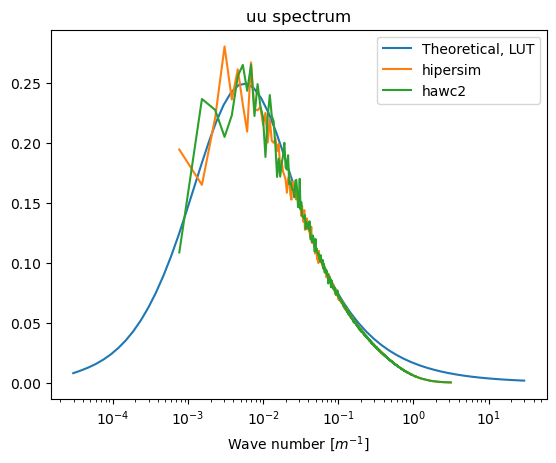

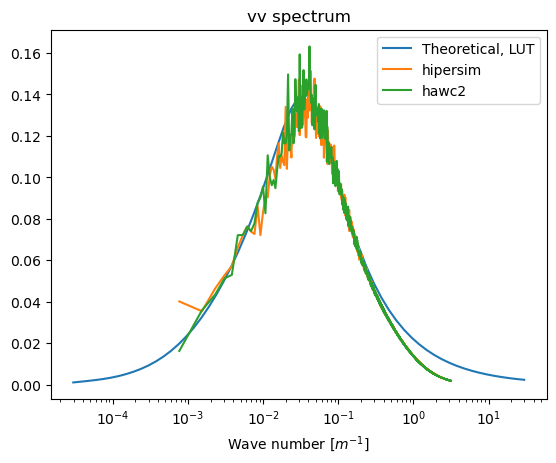

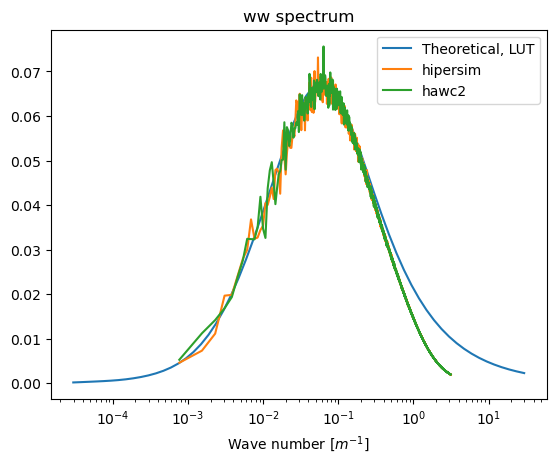

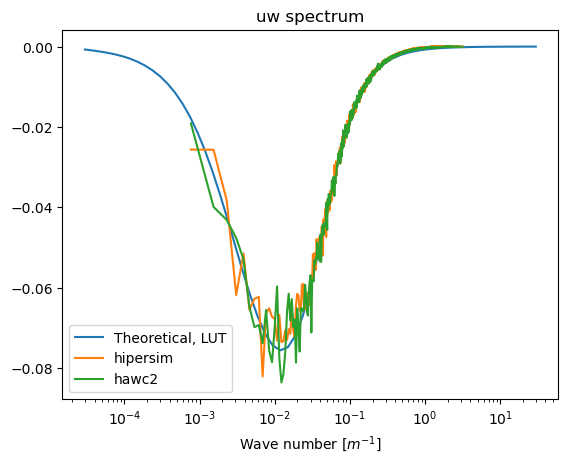

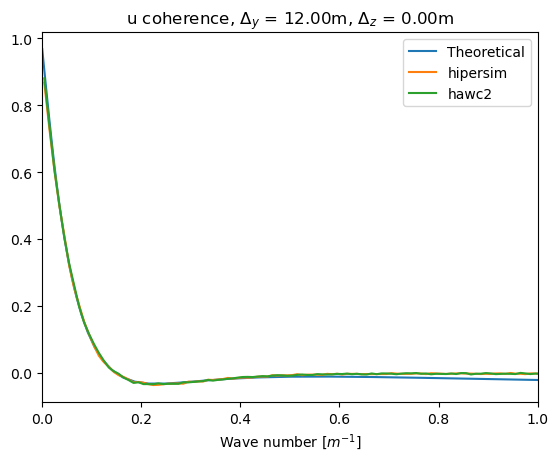

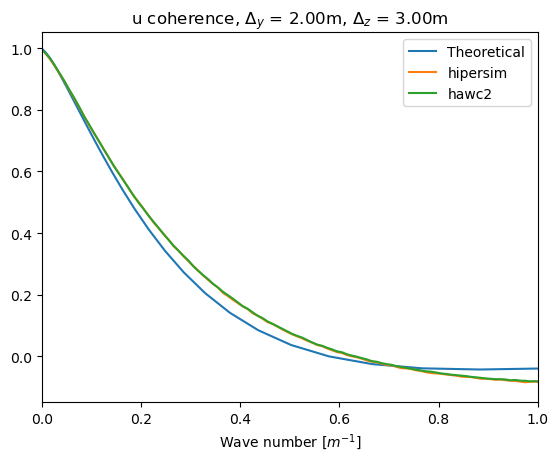

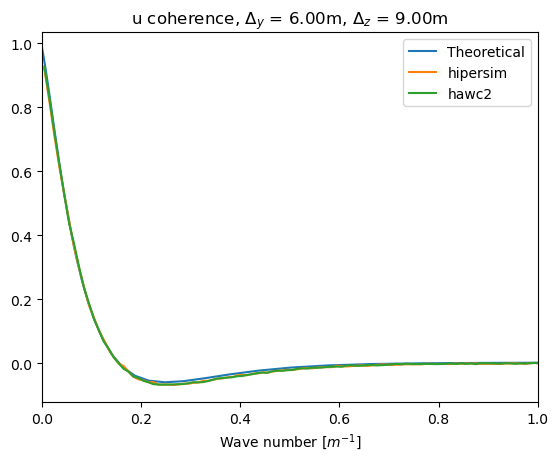

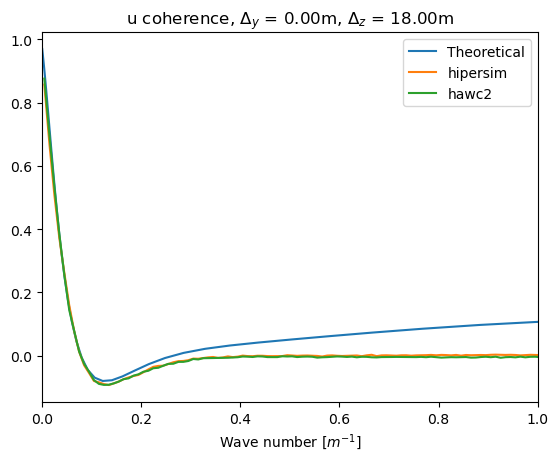

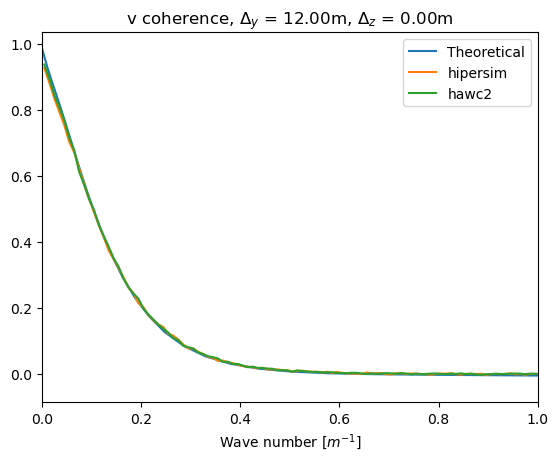

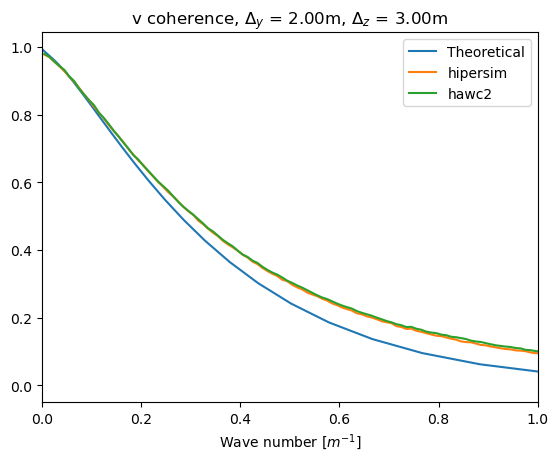

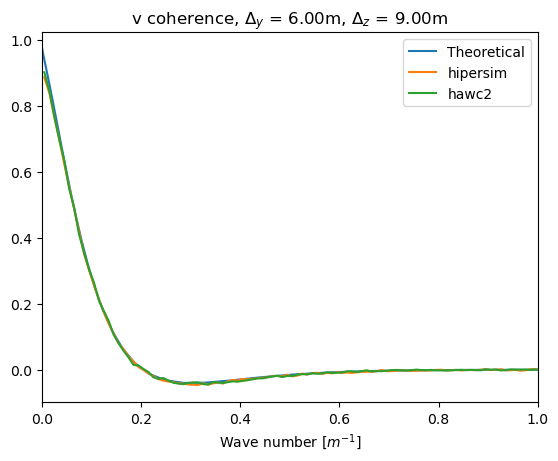

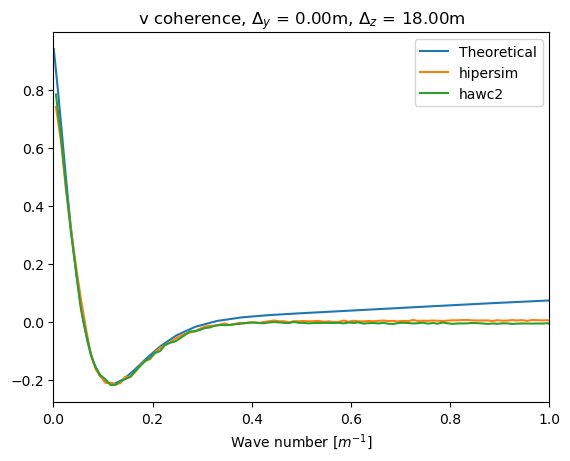

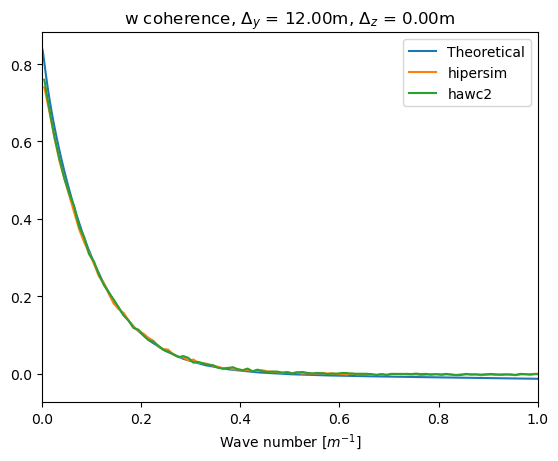

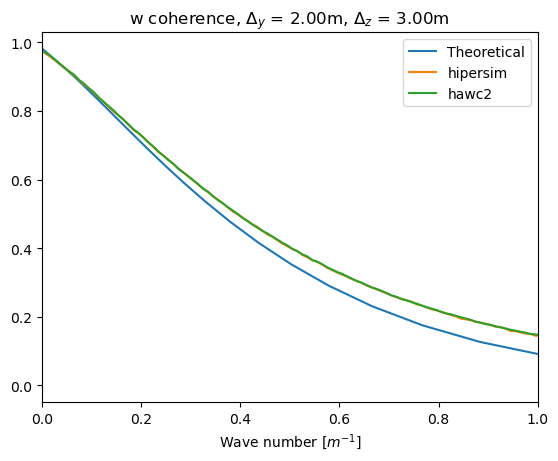

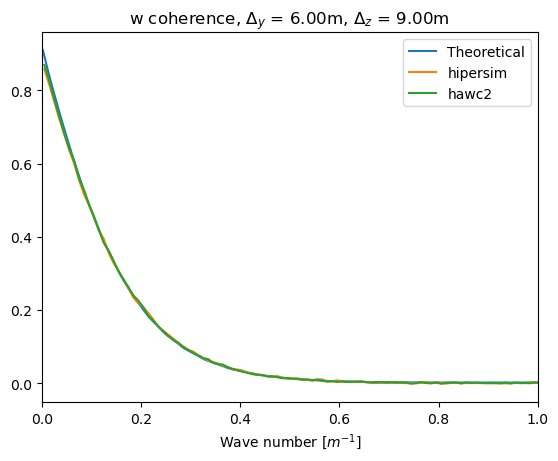

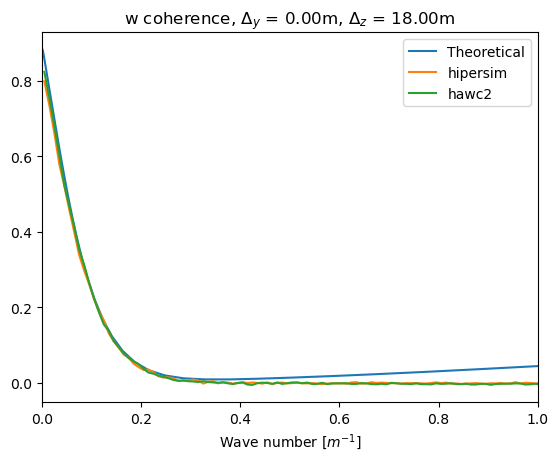

In [7]:
validate(mst_hfc0)

### With high-frequency compensation

In [8]:
mst_hfc2 = MannSpectralTensor(alphaepsilon=.1, 
                         L=33.6, 
                         Gamma=3.9, 
                         Nxyz=(8192,64,32),
                         dxyz=(1,2,3), 
                         HighFreqComp=2, 
                         double_xyz=(0,1,1))

hipersim:   0%|          | 0/32 [00:00<?, ?it/s]

hawc2:   0%|          | 0/32 [00:00<?, ?it/s]

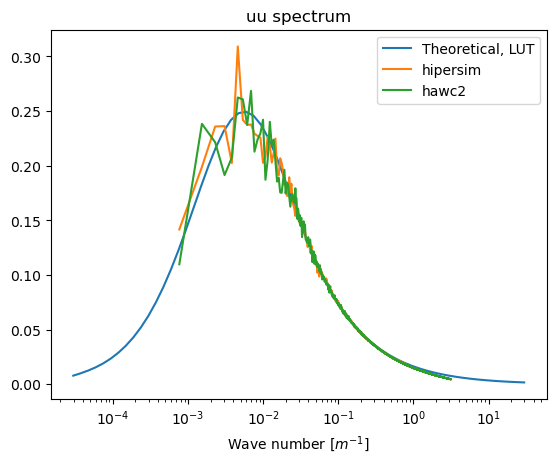

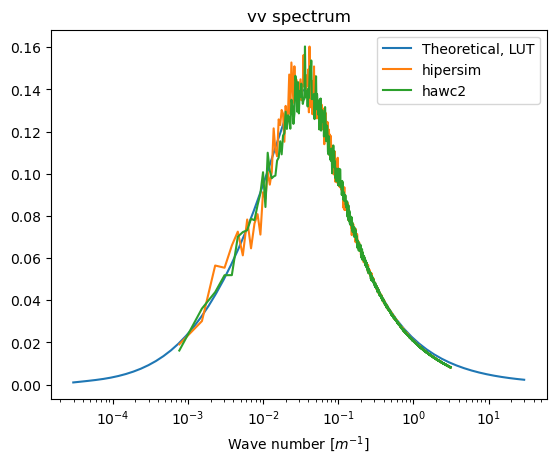

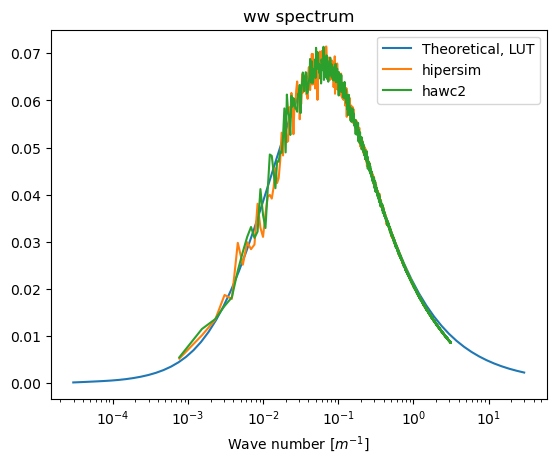

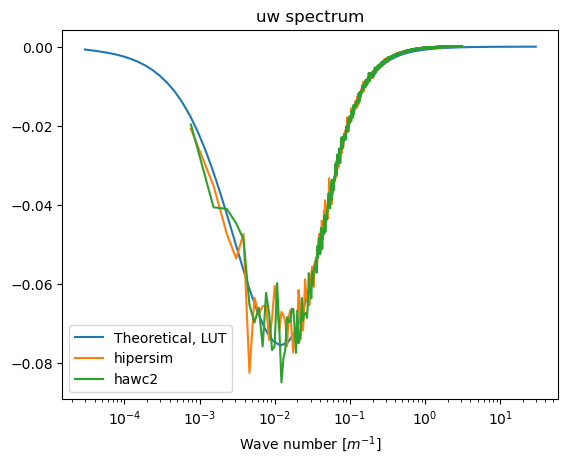

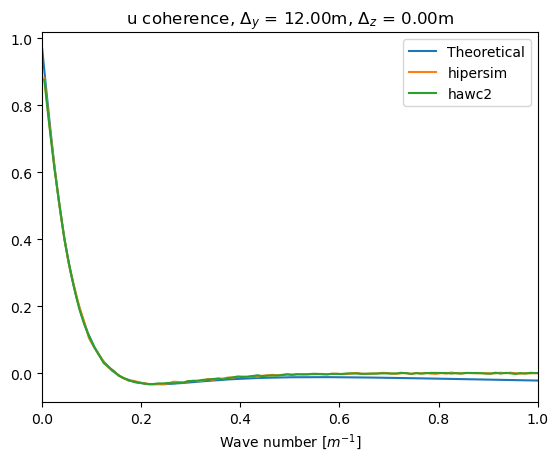

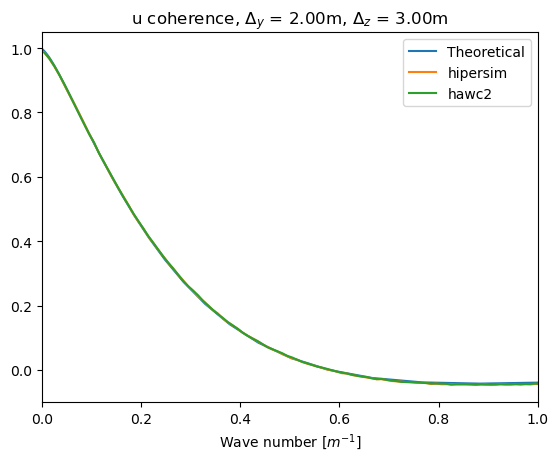

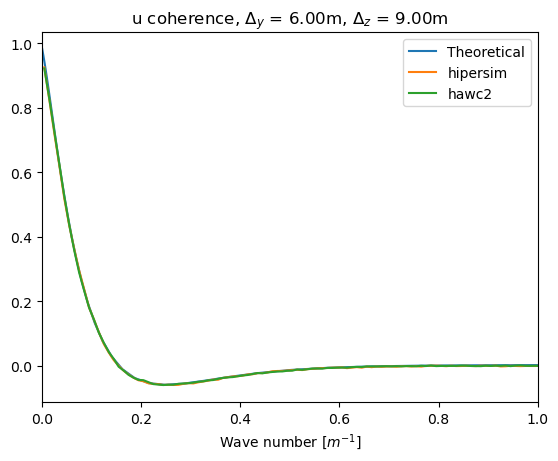

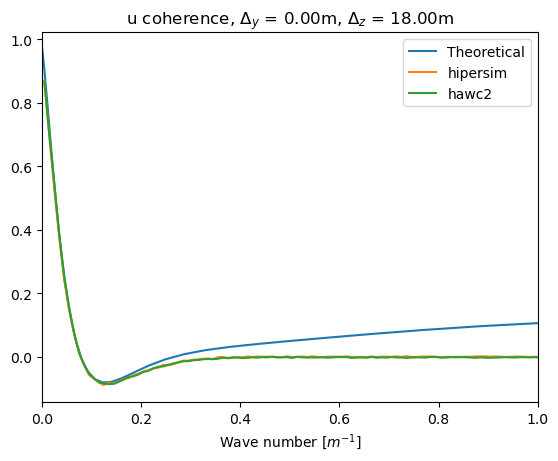

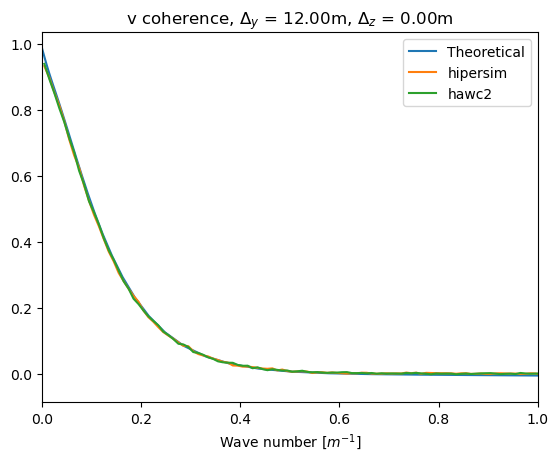

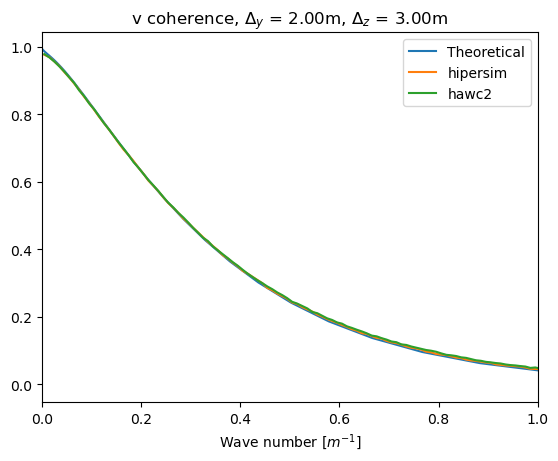

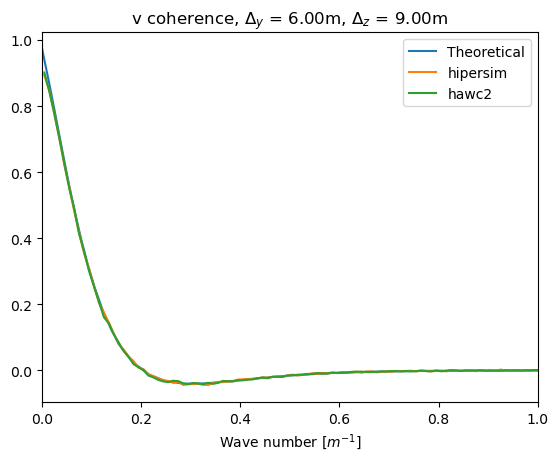

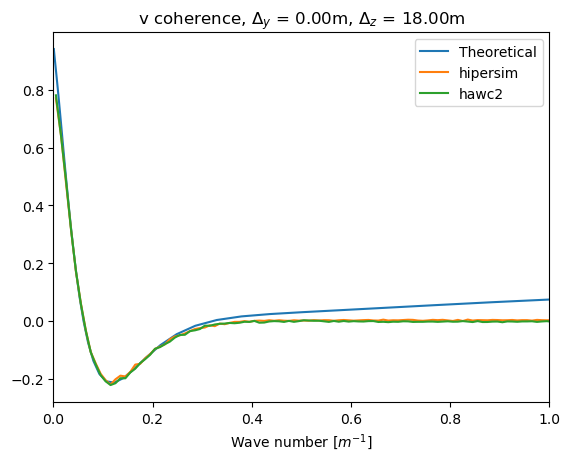

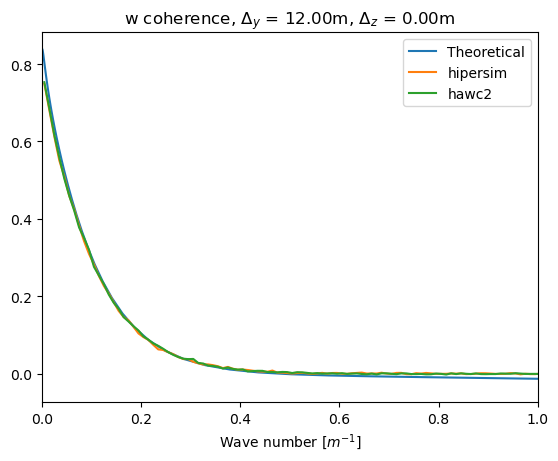

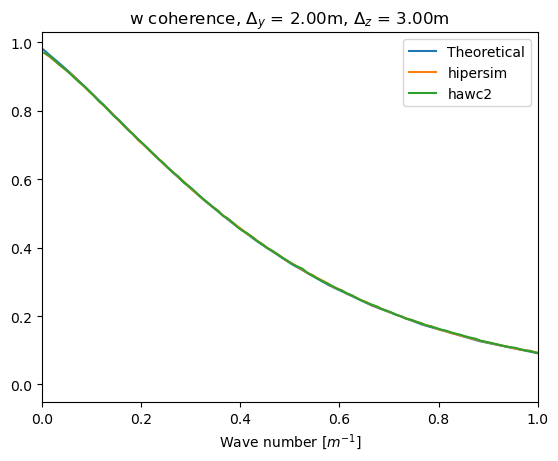

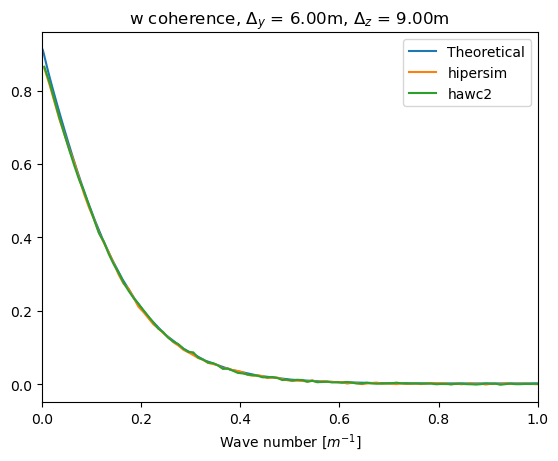

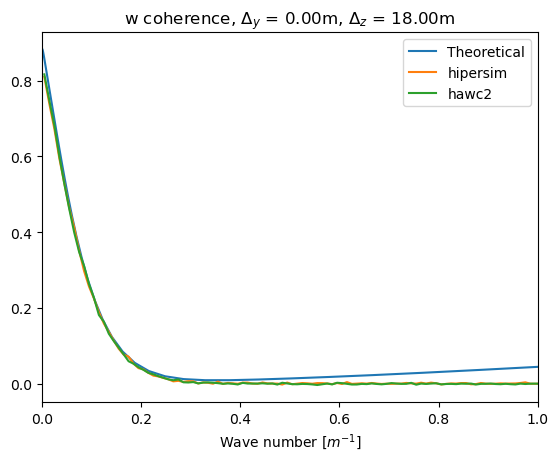

In [9]:
validate(mst_hfc2)